In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spec_id import Gen_spec
import seaborn as sea
import pandas as pd
from astropy.table import Table
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [9]:
spec = Gen_spec(galDB['gids'][61], galDB['hi_res_specz'][61],Av=0.0,attenuate=True,delayed=True,maxwv=11400)
spec.Sim_spec(galDB['Z_lwa'][61],galDB['t_lwa'][61],8.0)

../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


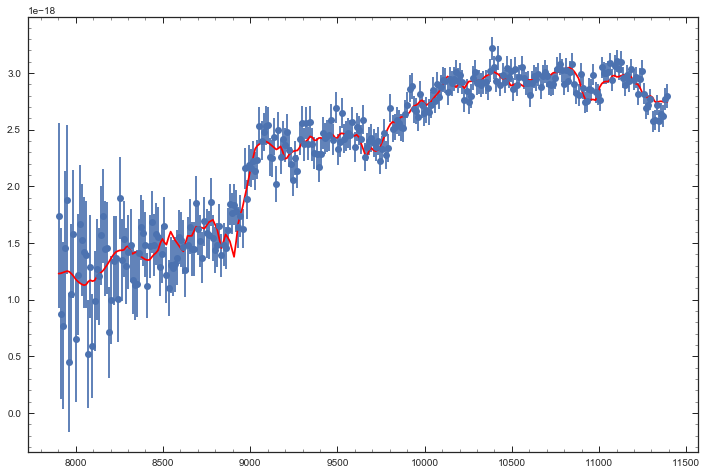

In [8]:
%matplotlib inline

plt.figure(figsize=[12,8])
plt.errorbar(spec.gal_wv,spec.gal_fl,spec.gal_er,fmt='o')
plt.plot(spec.gal_wv,spec.fl,'r')

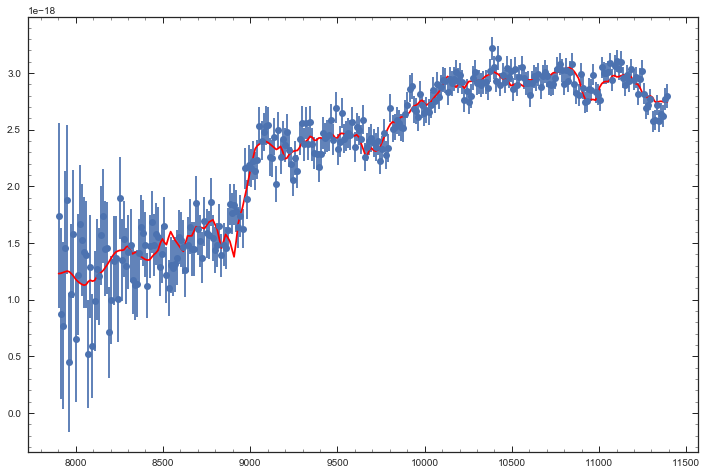

In [10]:
%matplotlib inline

plt.figure(figsize=[12,8])
plt.errorbar(spec.gal_wv,spec.gal_fl,spec.gal_er,fmt='o')
plt.plot(spec.gal_wv,spec.fl,'r')

In [4]:
north_fast=Table.read('../mini_catalogs/north.fout',format='ascii')
south_fast=Table.read('../mini_catalogs/south.fout',format='ascii')

In [7]:
AV=np.append(list(north_fast['col14']),list(south_fast['col14']))
AVl=AV - np.append(list(north_fast['col15']),list(south_fast['col15']))
AVh=np.append(list(north_fast['col16']),list(south_fast['col16'])) - AV

<Container object of 3 artists>

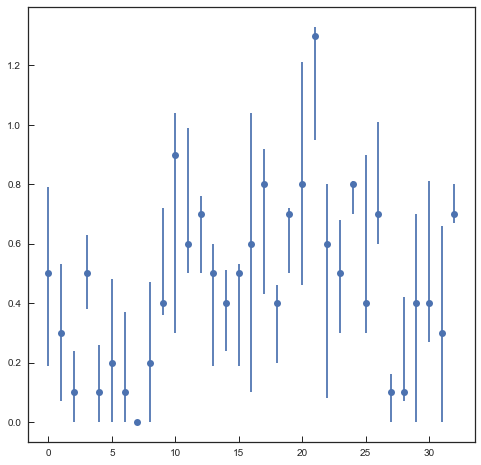

In [11]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.errorbar(np.arange(AV.size),AV,[AVl,AVh],fmt='o')

In [68]:
av=[0.0, 0.5, 0.3, 0.1, 0.5, 0.1, 0.2, 0.1, 0.0, 0.2, 0.0, 0.4, 0.9, 0.6, 0.7, 0.5, 0.4, 0.5, 0.6, 0.8,
    0.4, 0.7, 0.8, 1.3, 0.6, 0.5, 0.8, 0.4, 0.7, 0.1, 0.1, 0.4, 0.4, 0.3, 0.7]

In [69]:
len(av)

35

In [70]:
print np.array([galDB['gids'],av]).T

[['n14713' 0.0]
 ['n16758' 0.5]
 ['n17070' 0.3]
 ['n19442' 0.1]
 ['n21156' 0.5]
 ['n21427' 0.1]
 ['n23435' 0.2]
 ['n32566' 0.1]
 ['n34694' 0.0]
 ['n37686' 0.2]
 ['n38126' 0.0]
 ['s35774' 0.4]
 ['s38785' 0.9]
 ['s39012' 0.6]
 ['s39170' 0.7]
 ['s39241' 0.5]
 ['s39631' 0.4]
 ['s39804' 0.5]
 ['s39805' 0.6]
 ['s40223' 0.8]
 ['s40476' 0.4]
 ['s40597' 0.7]
 ['s40623' 0.8]
 ['s40862' 1.3]
 ['s41148' 0.6]
 ['s41520' 0.5]
 ['s41659' 0.8]
 ['s43615' 0.4]
 ['s44042' 0.7]
 ['s44620' 0.1]
 ['s45972' 0.1]
 ['s46066' 0.4]
 ['s46345' 0.4]
 ['s47677' 0.3]
 ['s48631' 0.7]]


In [71]:
galDB['A_v']=av

In [72]:
# galDB.to_pickle(('../data/sgal_param_DB.pkl'))

In [24]:
galDB

,gids,ids,ra,dec,hi_res_specz,lmass,tau,Z_f,Z_-_sig_f,Z_+_sig_f,...,Zx_lwa,Zx_-_sig_lwa,Zx_+_sig_lwa,Z_lwa,Z_-_sig_lwa,Z_+_sig_lwa,t_lwa,t_-_sig_lwa,t_+_sig_lwa,A_v
43,n14713,14713,189.236333,62.214608,1.232,10.56,8.78,0.018,0.011,0.008,...,0.015916,0.010156,0.009539,0.016,0.010,0.009,2.6,0.656,0.479,0.0
49,n16758,16758,189.162357,62.224840,1.014,10.83,0.00,0.020,0.001,0.002,...,0.020124,0.001403,0.002918,0.021,0.002,0.002,5.3,0.579,0.226,0.6
50,n17070,17070,189.268086,62.226445,1.192,10.92,8.48,0.011,0.003,0.004,...,0.010305,0.002581,0.004545,0.011,0.003,0.004,2.4,0.478,0.580,0.3
58,n19442,19442,189.123036,62.237460,1.101,10.10,8.90,0.015,0.009,0.010,...,0.013952,0.008305,0.010549,0.014,0.008,0.011,2.7,0.811,1.063,0.1
61,n21156,21156,189.239409,62.247548,1.251,11.16,8.30,0.020,0.005,0.004,...,0.019900,0.004545,0.004208,0.020,0.005,0.004,2.2,0.432,0.405,0.6
62,n21427,21427,189.368121,62.247344,1.514,10.73,8.48,0.019,0.010,0.007,...,0.017880,0.008641,0.008305,0.018,0.009,0.008,2.4,0.632,0.547,0.5
69,n23435,23435,189.338306,62.256571,1.134,10.27,8.60,0.014,0.006,0.009,...,0.014064,0.006172,0.009034,0.015,0.007,0.008,3.4,0.762,0.847,0.4
86,n32566,32566,189.161280,62.307577,1.150,10.61,8.70,0.020,0.008,0.006,...,0.019563,0.007743,0.006902,0.020,0.008,0.006,2.1,0.696,0.472,0.2
96,n34694,34694,189.147840,62.323647,1.145,10.94,8.30,0.015,0.006,0.005,...,0.014345,0.004882,0.005667,0.015,0.006,0.005,2.8,0.459,0.963,0.0
107,n37686,37686,189.274474,62.360820,1.258,10.89,8.48,0.016,0.003,0.004,...,0.015355,0.002357,0.004265,0.016,0.003,0.004,3.4,0.486,0.517,0.2


In [55]:
np.median(galDB['A_v'].values)

0.40000000000000002